In [156]:
import sys
#sys.path.remove('/Users/evsi8432/Documents/Research/CarHHMM-DFT/Repository/Code')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import vonmises
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.stats import circstd
from scipy.special import iv
from scipy.special import expit
from scipy.special import logit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d

from copy import deepcopy

import importlib

import time
import pickle

In [14]:
import Preprocessor
import Parameters
import HHMM
import Visualisor
import optimizor

from optimizor import eta_2_Gamma
from optimizor import Gamma_2_eta
from optimizor import logdotexp

# Initialize Parameters

In [15]:
# make parameters
pars = Parameters.Parameters()
pars.features = [{'Y':{'corr':False,'f':'normal'}}, # coarse-scale
                 {}]
pars.K = [3,1]
T = 100

# Simulate Data

In [16]:
N = 3
X = np.zeros(T,dtype=int)
data = []

# define parameters
Gamma = np.array([[0.5,0.25,0.25],
                  [0.25,0.5,0.25],
                  [0.25,0.25,0.5]])
delta = np.ones(pars.K[0])/pars.K[0]

mus = [-1,0,1]
sigs = [1.0,1.0,1.0]

for t in range(T):
    
    if t == 0:
        X[t] = np.random.choice(pars.K[0],p=delta)
    else:
        X[t] = np.random.choice(pars.K[0],p=Gamma[X[t-1]])

    data.append({'Y':mus[X[t]] + sigs[X[t]]*np.random.normal(),
                 'subdive_features':[]})

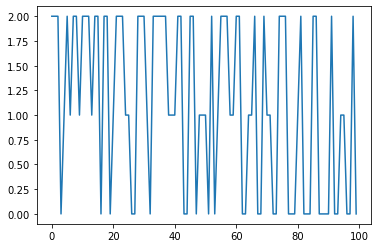

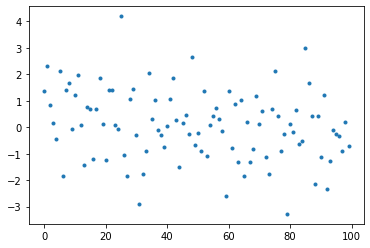

In [17]:
plt.plot(X)
plt.show()
plt.plot([x["Y"] for x in data],'.')
plt.show()

# Initialize optimizor and select intial values

In [138]:
# initialize objects
hhmm = HHMM.HHMM(pars,data)

hhmm.theta = [{'Y': {'mu': np.array([-2.0,  -1.0,  0.0]),
                     'log_sig': np.array([0.0, 0.0, 0.0]),
                     'corr': np.array([0.0, 0.0, 0.0])}},
               [{}, {}, {}]]

hhmm.Gamma = [np.array([[0.50, 0.25, 0.25],
                        [0.25, 0.50, 0.25],
                        [0.25, 0.25, 0.50]]),
               [np.array([[1.]]), np.array([[1.]]), np.array([[1.]])]]

hhmm.eta = Gamma_2_eta(hhmm.Gamma)

In [177]:
#L = 0.5*(4/np.exp(0))**2 # lipschitz constant

importlib.reload(optimizor)

optim1 = optimizor.optimizor(hhmm)
optim1.step_size = 1.5e-1
optim1.param_bounds["Y"]["mu"] = [-100,100]
optim1.param_bounds["Y"]["log_sig"] = [-1,1]

# set theta and eta to true values
optim2 = optimizor.optimizor(hhmm)
optim2.step_size = 3e-1 / T
optim2.param_bounds["Y"]["mu"] = [-100,100]
optim2.param_bounds["Y"]["log_sig"] = [-1,1]

# set theta and eta to true values
optim3 = optimizor.optimizor(hhmm)
optim3.step_size = 1e-1 / T
optim3.param_bounds["Y"]["mu"] = [-100,100]
optim3.param_bounds["Y"]["log_sig"] = [-1,1]

# print values
print(optim1.theta)
print(optim1.eta)
print(optim1.param_bounds)
print(optim1.step_size)

# print values
print(optim2.theta)
print(optim2.eta)
print(optim2.param_bounds)
print(optim2.step_size)

# print values
print(optim3.theta)
print(optim3.eta)
print(optim3.param_bounds)
print(optim3.step_size)

[{'Y': {'mu': array([-2., -1.,  0.]), 'log_sig': array([0., 0., 0.]), 'corr': array([0., 0., 0.])}}, [{}, {}, {}]]
[array([[ 0.        , -0.69314718, -0.69314718],
       [-0.69314718,  0.        , -0.69314718],
       [-0.69314718, -0.69314718,  0.        ]]), [array([[0.]]), array([[0.]]), array([[0.]])]]
{'Y': {'mu': [-100, 100], 'log_sig': [-1, 1]}}
0.15
[{'Y': {'mu': array([-2., -1.,  0.]), 'log_sig': array([0., 0., 0.]), 'corr': array([0., 0., 0.])}}, [{}, {}, {}]]
[array([[ 0.        , -0.69314718, -0.69314718],
       [-0.69314718,  0.        , -0.69314718],
       [-0.69314718, -0.69314718,  0.        ]]), [array([[0.]]), array([[0.]]), array([[0.]])]]
{'Y': {'mu': [-100, 100], 'log_sig': [-1, 1]}}
0.003
[{'Y': {'mu': array([-2., -1.,  0.]), 'log_sig': array([0., 0., 0.]), 'corr': array([0., 0., 0.])}}, [{}, {}, {}]]
[array([[ 0.        , -0.69314718, -0.69314718],
       [-0.69314718,  0.        , -0.69314718],
       [-0.69314718, -0.69314718,  0.        ]]), [array([[0.]]),

# Train the HMM

In [178]:
# do first optimization
num_epochs = 250
optim1.step_num = 1
optim1.train_HHMM(num_epochs,random_t=False,decay_ind=np.infty)

# do first optimization
num_epochs = 250
optim2.step_num = 1
optim2.train_HHMM(num_epochs,h=1,random_t=False,decay_ind=np.infty)

# do second optimization
num_epochs = 250
optim3.step_num = 1
optim3.train_HHMM(num_epochs,h=1,decay_ind=np.infty)

finished epoch num:  0
last direction:  forward
log-likelihood:  -200.8322430891539
finished epoch num:  1
last direction:  backward
log-likelihood:  -201.18681240601467
finished epoch num:  2
last direction:  forward
log-likelihood:  -196.51450600784193
finished epoch num:  3
last direction:  backward
log-likelihood:  -199.48978609312465
finished epoch num:  4
last direction:  forward
log-likelihood:  -204.0735698279049
finished epoch num:  5
last direction:  backward
log-likelihood:  -349.59221643441464
finished epoch num:  6
last direction:  forward
log-likelihood:  -269.1090076745673
finished epoch num:  7
last direction:  backward
log-likelihood:  -328.8328698699343
finished epoch num:  8
last direction:  forward
log-likelihood:  -8215.330732450166
finished epoch num:  9
last direction:  backward
log-likelihood:  -12508.118218159208
finished epoch num:  10
last direction:  forward
log-likelihood:  -16148.140602980131
finished epoch num:  11
last direction:  backward
log-likelihood

finished epoch num:  98
last direction:  forward
log-likelihood:  -499328.51504914725
finished epoch num:  99
last direction:  backward
log-likelihood:  -500758.0517872814
finished epoch num:  100
last direction:  forward
log-likelihood:  -499328.51504914725
finished epoch num:  101
last direction:  backward
log-likelihood:  -500758.0517872814
finished epoch num:  102
last direction:  forward
log-likelihood:  -499328.51504914725
finished epoch num:  103
last direction:  backward
log-likelihood:  -500758.0517872814
finished epoch num:  104
last direction:  forward
log-likelihood:  -499328.51504914725
finished epoch num:  105
last direction:  backward
log-likelihood:  -500758.0517872814
finished epoch num:  106
last direction:  forward
log-likelihood:  -499328.51504914725
finished epoch num:  107
last direction:  backward
log-likelihood:  -500758.0517872814
finished epoch num:  108
last direction:  forward
log-likelihood:  -499328.51504914725
finished epoch num:  109
last direction:  bac

finished epoch num:  197
last direction:  backward
log-likelihood:  -500758.0517872814
finished epoch num:  198
last direction:  forward
log-likelihood:  -499328.51504914725
finished epoch num:  199
last direction:  backward
log-likelihood:  -500758.0517872814
finished epoch num:  200
last direction:  forward
log-likelihood:  -499328.51504914725
finished epoch num:  201
last direction:  backward
log-likelihood:  -500758.0517872814
finished epoch num:  202
last direction:  forward
log-likelihood:  -499328.51504914725
finished epoch num:  203
last direction:  backward
log-likelihood:  -500758.0517872814
finished epoch num:  204
last direction:  forward
log-likelihood:  -499328.51504914725
finished epoch num:  205
last direction:  backward
log-likelihood:  -500758.0517872814
finished epoch num:  206
last direction:  forward
log-likelihood:  -499328.51504914725
finished epoch num:  207
last direction:  backward
log-likelihood:  -500758.0517872814
finished epoch num:  208
last direction:  f

finished epoch num:  43
last direction:  backward
log-likelihood:  -169547.26904026687
finished epoch num:  44
last direction:  forward
log-likelihood:  -236518.89317884826
finished epoch num:  45
last direction:  backward
log-likelihood:  -250775.32045380943
finished epoch num:  46
last direction:  forward
log-likelihood:  -107684.3312165585
finished epoch num:  47
last direction:  backward
log-likelihood:  -52558.27593982961
finished epoch num:  48
last direction:  forward
log-likelihood:  -11752.141009987743
finished epoch num:  49
last direction:  backward
log-likelihood:  -38438.6601489409
finished epoch num:  50
last direction:  forward
log-likelihood:  -62138.91585190021
finished epoch num:  51
last direction:  backward
log-likelihood:  -209068.83211154363
finished epoch num:  52
last direction:  forward
log-likelihood:  -187158.00731079103
finished epoch num:  53
last direction:  backward
log-likelihood:  -107308.51695319184
finished epoch num:  54
last direction:  forward
log-

finished epoch num:  142
last direction:  forward
log-likelihood:  -156050.74160145543
finished epoch num:  143
last direction:  backward
log-likelihood:  -70259.63841733534
finished epoch num:  144
last direction:  forward
log-likelihood:  -75265.8935918755
finished epoch num:  145
last direction:  backward
log-likelihood:  -263989.7621857672
finished epoch num:  146
last direction:  forward
log-likelihood:  -38783.58484335963
finished epoch num:  147
last direction:  backward
log-likelihood:  -40449.28615882992
finished epoch num:  148
last direction:  forward
log-likelihood:  -240126.60055265075
finished epoch num:  149
last direction:  backward
log-likelihood:  -78008.63891017195
finished epoch num:  150
last direction:  forward
log-likelihood:  -142117.66057244697
finished epoch num:  151
last direction:  backward
log-likelihood:  -137763.32330175742
finished epoch num:  152
last direction:  forward
log-likelihood:  -91900.26396745481
finished epoch num:  153
last direction:  back

finished epoch num:  237
last direction:  backward
log-likelihood:  -76720.58726289112
finished epoch num:  238
last direction:  forward
log-likelihood:  -156050.74160145543
finished epoch num:  239
last direction:  backward
log-likelihood:  -70259.63841733534
finished epoch num:  240
last direction:  forward
log-likelihood:  -75265.8935918755
finished epoch num:  241
last direction:  backward
log-likelihood:  -263989.7621857672
finished epoch num:  242
last direction:  forward
log-likelihood:  -38783.58484335963
finished epoch num:  243
last direction:  backward
log-likelihood:  -40449.28615882992
finished epoch num:  244
last direction:  forward
log-likelihood:  -240126.60055265075
finished epoch num:  245
last direction:  backward
log-likelihood:  -78008.63891017195
finished epoch num:  246
last direction:  forward
log-likelihood:  -142117.66057244697
finished epoch num:  247
last direction:  backward
log-likelihood:  -137763.32330175742
finished epoch num:  248
last direction:  for

finished epoch num:  84
last direction:  forward
log-likelihood:  -249.99408644985982
finished epoch num:  85
last direction:  backward
log-likelihood:  -250.01013011978216
finished epoch num:  86
last direction:  forward
log-likelihood:  -245.18067200679153
finished epoch num:  87
last direction:  backward
log-likelihood:  -253.394614762152
finished epoch num:  88
last direction:  forward
log-likelihood:  -250.47638109770537
finished epoch num:  89
last direction:  backward
log-likelihood:  -250.2566571883363
finished epoch num:  90
last direction:  forward
log-likelihood:  -250.63048988146983
finished epoch num:  91
last direction:  backward
log-likelihood:  -248.2268694578621
finished epoch num:  92
last direction:  forward
log-likelihood:  -250.3170868435643
finished epoch num:  93
last direction:  backward
log-likelihood:  -248.8555719373839
finished epoch num:  94
last direction:  forward
log-likelihood:  -251.26630417354664
finished epoch num:  95
last direction:  backward
log-l

finished epoch num:  181
last direction:  backward
log-likelihood:  -248.10176436833837
finished epoch num:  182
last direction:  forward
log-likelihood:  -247.80528438271725
finished epoch num:  183
last direction:  backward
log-likelihood:  -248.1003665610453
finished epoch num:  184
last direction:  forward
log-likelihood:  -248.1660451250092
finished epoch num:  185
last direction:  backward
log-likelihood:  -248.0982136426952
finished epoch num:  186
last direction:  forward
log-likelihood:  -248.05896729376036
finished epoch num:  187
last direction:  backward
log-likelihood:  -248.179947933317
finished epoch num:  188
last direction:  forward
log-likelihood:  -248.22473285403112
finished epoch num:  189
last direction:  backward
log-likelihood:  -248.19401571455734
finished epoch num:  190
last direction:  forward
log-likelihood:  -248.31332758166639
finished epoch num:  191
last direction:  backward
log-likelihood:  -248.19320710392373
finished epoch num:  192
last direction:  

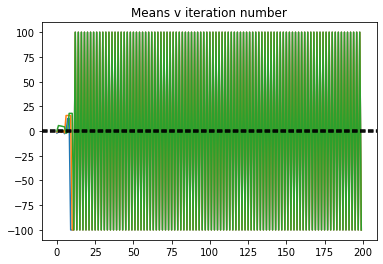

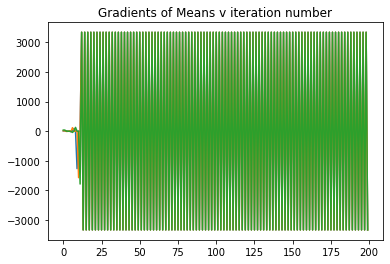

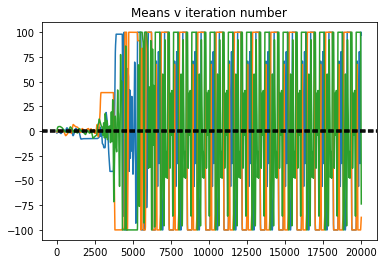

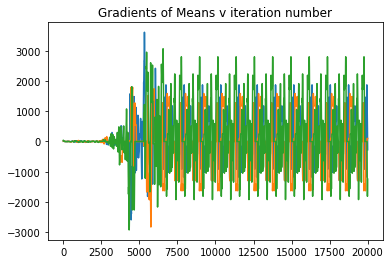

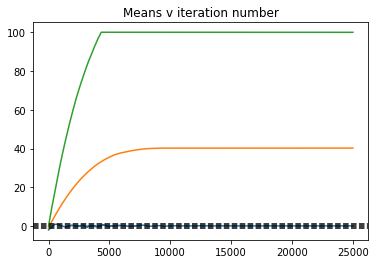

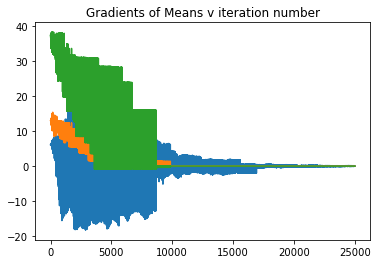

In [180]:
def plot_results(optim,iters=None):
    
    if iters is None:
        iters=len(optim.theta_trace)
    
    #plt.plot(optim.log_like_trace)
    #plt.title("Log-likelihood v iteration number")
    #plt.show()

    plt.plot([optim.theta_trace[i][0]['Y']['mu'][0] for i in range(iters)])
    plt.plot([optim.theta_trace[i][0]['Y']['mu'][1] for i in range(iters)])
    plt.plot([optim.theta_trace[i][0]['Y']['mu'][2] for i in range(iters)])
    plt.title("Means v iteration number")
    for hline in [-1,0,1]:
        plt.axhline(hline, c = 'k', linestyle = "--")
    #plt.axhline(optim.param_bounds['Y']['mu'][1], c = 'k', linestyle = "--")
    #plt.axhline(optim.param_bounds['Y']['mu'][0], c = 'k', linestyle = "--")
    #plt.axhline(optim.param_bounds['Y']['mu'][1], c = 'k', linestyle = "--")
    plt.show()
    
    plt.plot([optim.theta_trace[i][0]['Y']['log_sig'][0] for i in range(len(optim.theta_trace))])
    plt.plot([optim.theta_trace[i][0]['Y']['log_sig'][1] for i in range(len(optim.theta_trace))])
    plt.plot([optim.theta_trace[i][0]['Y']['log_sig'][2] for i in range(len(optim.theta_trace))])
    plt.axhline(optim.param_bounds['Y']['log_sig'][0], c = 'k', linestyle = "--")
    plt.axhline(optim.param_bounds['Y']['log_sig'][1], c = 'k', linestyle = "--")
    plt.title("Standard Deviations v iteration number")
    #plt.show()
    
    #plt.plot([optim.eta_trace[i][0][0,1] for i in range(len(optim.eta_trace))])
    #plt.plot([optim.eta_trace[i][0][0,2] for i in range(len(optim.eta_trace))])
    #plt.plot([optim.eta_trace[i][0][1,0] for i in range(len(optim.eta_trace))])
    #plt.plot([optim.eta_trace[i][0][1,2] for i in range(len(optim.eta_trace))])
    #plt.plot([optim.eta_trace[i][0][2,0] for i in range(len(optim.eta_trace))])
    #plt.plot([optim.eta_trace[i][0][2,1] for i in range(len(optim.eta_trace))])
    #plt.title("Eta v iteration number")
    #plt.show()

    plt.plot([optim.grad_theta_trace[i][0]['Y']['mu'][0] for i in range(iters)])#range(len(optim.theta_trace))])
    plt.plot([optim.grad_theta_trace[i][0]['Y']['mu'][1] for i in range(iters)])#range(len(optim.theta_trace))])
    plt.plot([optim.grad_theta_trace[i][0]['Y']['mu'][2] for i in range(iters)])#range(len(optim.theta_trace))])
    plt.title("Gradients of Means v iteration number")
    plt.show()
    
    #plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][0] for i in range(len(optim.theta_trace))])
    #plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][1] for i in range(len(optim.theta_trace))])
    #plt.plot([optim.grad_theta_trace[i][0]['Y']['log_sig'][2] for i in range(len(optim.theta_trace))])
    #plt.title("Gradients of Standard Deviations v iteration number")
    #plt.show()
    
plot_results(optim1,iters=200)
plot_results(optim2,iters=20000)
plot_results(optim3)

# Make sure that the likelihoods agree

-200.83224308915388



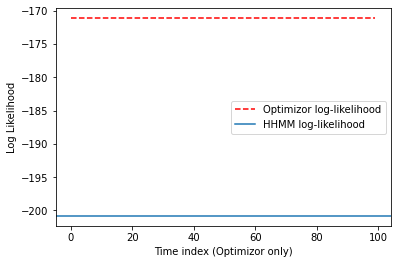

In [118]:
# using hhmm
print(hhmm.likelihood(data))
print("")
# do a forward pass and backwards pass
optim1.fwd_pass()
optim1.bwd_pass()

# print likelihood of evaluated at each time point
lls = [optim1.log_likelihood(t) for t in range(optim1.T)]
plt.plot(lls,"r--")
plt.axhline(hhmm.likelihood(data))
plt.legend(["Optimizor log-likelihood","HHMM log-likelihood"])
plt.xlabel("Time index (Optimizor only)")
plt.ylabel("Log Likelihood")
plt.show()

# Test that the gradients wrt $\theta$ agree

In [11]:
# test gradient of mu_Y for state 0 using my hand-code (this is mu2)
optim.fwd_pass(data)
optim.bwd_pass(data)

autograds = np.zeros(optim.T)
finite_diffs = np.zeros(optim.T)

for t in range(optim.T):

    optim.grad_log_likelihood(t)
    autograds[t] = optim.d_log_like_d_theta[t][0]["Y"]["mu"][2]

    # test finte differences - optim
    eps = 0.0001
    
    # record current likelihood
    y1 = np.copy(optim.log_likelihood(t))
    
    # adjust parameters and record result
    optim.theta[0]['Y']['mu'][2] += eps
    optim.fwd_pass(data)
    optim.bwd_pass(data)
    y2 = np.copy(optim.log_likelihood(t))

    # record the finite difference
    finite_diffs[t] = (y2-y1)/eps

    # change the parameters back
    optim.theta[0]['Y']['mu'][2] += -eps
    optim.fwd_pass(data)
    optim.bwd_pass(data)
    
plt.plot(autograds)
plt.plot(finite_diffs)

NameError: name 'optim' is not defined

# Test that the gradients wrt $\eta$ agree

In [ ]:
# test gradient of mu_Y for state 0 using my hand-code (this is mu2)
optim.fwd_pass(data)
optim.bwd_pass(data)

autograds = np.zeros(optim.T)
finite_diffs = np.zeros(optim.T)

for t in range(optim.T):

    optim.grad_log_likelihood(t)
    autograds[t] = optim.d_log_like_d_eta[t][0,1]

    # test finte differences - optim
    eps = 0.0001
    
    # record current likelihood
    y1 = np.copy(optim.log_likelihood(t))
    
    # adjust parameters and record result
    optim.eta[0][0,1] += eps
    optim.Gamma = eta_2_Gamma(optim.eta)
    optim.fwd_pass(data)
    optim.bwd_pass(data)
    y2 = np.copy(optim.log_likelihood(t))

    # record the finite difference
    finite_diffs[t] = (y2-y1)/eps

    # change the parameters back
    optim.eta[0][0,1] += -eps
    optim.Gamma = eta_2_Gamma(optim.eta)
    optim.fwd_pass(data)
    optim.bwd_pass(data)
    
print(autograds)
print(finite_diffs)
plt.plot(autograds)
plt.plot(finite_diffs)

In [ ]:
np.clip(np.array([-1,0,1]),-0.5,0.5)